[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ClimateMatchAcademy/course-content/blob/main/tutorials/W1D1_ClimateSystemOverview/student/W1D1_Tutorial2.ipynb)   <a href="https://kaggle.com/kernels/welcome?src=https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/tutorials/W1D1_ClimateSystemOverview/student/W1D1_Tutorial2.ipynb" target="_blank"><img alt="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"/></a>

# **Tutorial 2: Selection, Interpolation and Slicing**

**Week 1, Day 1, Climate System Overview**

**Content creators:** Sloane Garelick, Julia Kent

**Content reviewers:** Katrina Dobson, Younkap Nina Duplex, Danika Gupta, Maria Gonzalez, Will Gregory, Nahid Hasan, Sherry Mi, Beatriz Cosenza Muralles, Jenna Pearson, Agustina Pesce, Chi Zhang, Ohad Zivan

**Content editors:** Jenna Pearson, Chi Zhang, Ohad Zivan

**Production editors:** Wesley Banfield, Jenna Pearson, Chi Zhang, Ohad Zivan

**Our 2023 Sponsors:** NASA TOPS and Google deepmind

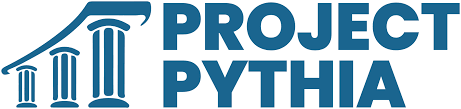 | 
-
Pythia credit: Rose, B. E. J., Kent, J., Tyle, K., Clyne, J., Banihirwe, A., Camron, D., May, R., Grover, M., Ford, R. R., Paul, K., Morley, J., Eroglu, O., Kailyn, L., & Zacharias, A. (2023). Pythia Foundations (Version v2023.05.01) https://zenodo.org/record/8065851



# **Tutorial Objectives**
In the previous tutorial, we learned how to use `Xarray` to create `DataArray` and `Dataset` objects. Global climate datasets can be very large with multiple variables, and DataArrays and Datasets are very useful tools for organizing, comparing and interpreting such data. However, sometimes we are not interested in examining a *global* dataset but wish to examine a specific time or location. For example, we might want to look at climate variables in a particular region of Earth, and potentially compare that to another region. In order to carry-out such analyses, it’s useful to be able to extract and compare subsets of data from a global dataset. 

In this tutorial, you will explore multiple computational tools in `Xarray` that allow you to select data from a specific spatial and temporal range. In particular, you will practice using:


*   **`.sel()`:** select data based on coordinate values or date
*   **`.interp()`:** interpolate to any latitude/longitude location to extract data
*   **`slice()`:** to select a range (or slice) along one or more coordinates, we can pass a Python slice object to `.sel()`


# **Setup**

In [ ]:
# imports
from datetime import timedelta
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

##  Figure Settings


###  Figure Settings


####  Figure Settings


#####  Figure Settings


In [ ]:
# @title Figure Settings
import ipywidgets as widgets       # interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/ClimateMatchAcademy/course-content/main/cma.mplstyle")

##  Video 1: Video Title


###  Video 1: Video Title


####  Video 1: Video Title


#####  Video 1: Video Title


In [ ]:
# @title Video 1: Video Title
#Tech team will add code to format and display the video

To explore these Xarray tools, first recreate the synthetic temperature and pressure DataArrays you generated in the previous tutorial, and combine these two DataArrays into a Dataset.

# **Section 1: Subsetting and Selection by Coordinate Values**

Since Xarray allows us to label coordinates, you can select data based on coordinate names and values, rather than array indices. We'll explore this briefly here. First, we will recreate the temperature and pressure data from Tutorial 1.

In [ ]:
# temperature data
rand_data = 283 + 5 * np.random.randn(5, 3, 4)
times_index = pd.date_range('2018-01-01', periods=5)
lons = np.linspace(-120, -60, 4)
lats = np.linspace(25, 55, 3)
temperature = xr.DataArray(rand_data, coords=[times_index, lats, lons], dims=['time', 'lat', 'lon'])
temperature.attrs['units'] = 'kelvin'
temperature.attrs['standard_name'] = 'air_temperature'

# pressure data
pressure_data = 1000.0 + 5 * np.random.randn(5, 3, 4)
pressure = xr.DataArray(
    pressure_data, coords=[times_index, lats, lons], dims=['time', 'lat', 'lon']
)
pressure.attrs['units'] = 'hPa'
pressure.attrs['standard_name'] = 'air_pressure'

# combinate temperature and pressure DataArrays into a Dataset called 'ds'
ds = xr.Dataset(data_vars={'Temperature': temperature, 'Pressure': pressure})
ds

To refresh your memory from the previous tutorial, take a look at the DataArrays you created for temperature and pressure by clicking on those variables in the dataset above.


## **Section 1.1: NumPy-like Selection**

Suppose you want to extract all the spatial data for one single date: January 2, 2018. It's possible to achieve that with NumPy-like index selection:

In [ ]:
indexed_selection = temperature[1, :, :]  # index 1 along axis 0 is the time slice we want...
indexed_selection

However, notice that this requires us (the user) to have detailed knowledge of the order of the axes and the meaning of the indices along those axes. By having named coordinates in Xarray, we can avoid this issue.

## **Section 1.2: `.sel()`**

Rather than using a NumPy-like index selection, in Xarray, we can instead select data based on coordinate values using the `.sel()` method, which takes one or more named coordinate(s) as a keyword argument:

In [ ]:
named_selection = temperature.sel(time='2018-01-02')
named_selection

We got the same result as when we used the NumPy-like index selection, but 
- we didn't have to know anything about how the array was created or stored
- our code is agnostic about how many dimensions we are dealing with
- the intended meaning of our code is much clearer!

By using the .sel() method in Xarray, we can easily isolate data from a specific time. You can also isolate data from a specific coordinate. 

### **Coding Exercises 1.2**

1. Write a line of code to select the temperature data from the coordinates 25,-120.

In [ ]:
coordinate_selection = ...
coordinate_selection

[*Click for solution*](https://github.com/ClimateMatchAcademy/course-content/tree/main/tutorials/W1D1_ClimateSystemOverview/solutions/W1D1_Tutorial2_Solution_2995e798.py)



## **Section 1.3: Approximate Selection and Interpolation**

The spatial and temporal resolution of climate data often differs between datasets or a dataset may be incomplete. Therefore, with time and space data, we frequently want to sample "near" the coordinate points in our dataset. For example, we may want to analyze data from a specific coordinate or a specific time, but may not have a value from that specific location or date. In that case, we would want to use the data from the closest coordinate or time-step. Here are a few simple ways to achieve that.

### **Section 1.3.1: Nearest-neighbor Sampling**

Suppose we want to know the temperature from `2018-01-07`. However, the last day on our `time` axis is `2018-01-05`. We can therefore sample within two days of our desired date of `2018-01-07`. We can do this using the `.sel` method we used earlier, but with the added flexibility of performing [nearest neighbor sampling](https://docs.xarray.dev/en/stable/user-guide/indexing.html#nearest-neighbor-lookups) and specifying an optional tolerance. This is called an **inexact lookup** because we are not searching for a perfect match, although there may be one. Here the **tolerance** is the maximum distance away from our desired point Xarray will search for a nearest neighbor.

In [ ]:
temperature.sel(time='2018-01-07', method='nearest', tolerance=timedelta(days=2))

Notice that the resulting data is from the date `2018-01-05`.

### **Section 1.3.2:  Interpolation**

The latitude values of our dataset are 25ºN, 40ºN, 55ºN, and the longitude values are 120ºW, 100ºW, 80ºW, 60ºW. But suppose we want to extract a timeseries for Boulder, Colorado, USA (40°N, 105°W). Since `lon=-105` is _not_ a point on our longitude axis, this requires interpolation between data points.

We can do this using the `.interp()` method (see the docs [here](http://xarray.pydata.org/en/stable/interpolation.html)), which works similarly to `.sel()`. Using `.interp()`, we can interpolate to any latitude/longitude location using an interpolation method of our choice. In the example below, you will linearly interpolate between known points.

In [ ]:
temperature.interp(lon=-105, lat=40, method='linear')

In this case, we specified a linear interpolation method, yet one can choose other methods as well (e.g., nearest, cubic, quadratic). Note that the temperature values we extracted in the code cell above are not actual values in the dataset, but are instead calculated based on linear interpolations between values that are in the dataset.

## **Section 1.4: Slicing Along Coordinates**

Frequently we want to select a range (or _slice_) along one or more coordinate(s). For example, you may wish to only assess average annual temperatures in equatorial regions. We can achieve this by passing a Python [slice](https://docs.python.org/3/library/functions.html#slice) object to `.sel()`. The calling sequence for <code>slice</code> always looks like <code>slice(start, stop[, step])</code>, where <code>step</code> is optional. In this case, let's only look at values between 110ºW-70ºW and 25ºN-40ºN:

In [ ]:
temperature.sel(
    time=slice('2018-01-01', '2018-01-03'), lon=slice(-110, -70), lat=slice(25, 45)
)

## **Section 1.5: One More Selection Method: `.loc`**

All of these operations can also be done within square brackets on the `.loc` attribute of the `DataArray`:


In [ ]:
 temperature.loc['2018-01-02']

This is sort of in between the NumPy-style selection
```
temp[1,:,:]
```
and the fully label-based selection using `.sel()`

With `.loc`, we make use of the coordinate *values*, but lose the ability to specify the *names* of the various dimensions. Instead, the slicing must be done in the correct order:

In [ ]:
 temperature.loc['2018-01-01':'2018-01-03', 25:45, -110:-70]

One advantage of using `.loc` is that we can use NumPy-style slice notation like `25:45`, rather than the more verbose `slice(25,45)`. But of course that also works:

In [ ]:
temperature.loc['2018-01-01':'2018-01-03', slice(25, 45), -110:-70]

What *doesn't* work is passing the slices in a different order to the dimensions of the dataset:

In [ ]:
# This will generate an error
# temperature.loc[-110:-70, 25:45,'2018-01-01':'2018-01-03']

# **Summary**

In this tutorial, we have explored the practical use of **`.sel()`** **`.interp()`** **`.loc()`:** and **slicing** techniques to extract data from specific spatial and temporal ranges. These methods are valuable when we are intereseted in only certain pieces of large datasets.

# **Resources**

Code and data for this tutorial is based on existing content from [Project Pythia](https://foundations.projectpythia.org/core/xarray/xarray-intro.html).